In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt


In [9]:
def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    """
    Applies a bandpass Butterworth filter to a signal.

    Args:
        signal (np.ndarray): The input signal.
        lowcut (float): The lower cutoff frequency of the bandpass filter.
        highcut (float): The upper cutoff frequency of the bandpass filter.
        fs (float): The sampling rate of the signal.
        order (int): The order of the Butterworth filter.

    Returns:
        np.ndarray: The filtered signal.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Ensure cutoff frequencies are within Nyquist limit
    if low >= 1.0:
        print(f"Warning: Lower cutoff frequency {lowcut}Hz is at or above Nyquist limit {nyq}Hz. Adjusting to 0.99*Nyquist.")
        low = 0.99
    if high >= 1.0:
        print(f"Warning: Upper cutoff frequency {highcut}Hz is at or above Nyquist limit {nyq}Hz. Adjusting to 0.99*Nyquist.")
        high = 0.99
    if low >= high:
        print(f"Warning: Lower cutoff frequency {lowcut}Hz is >= upper cutoff frequency {highcut}Hz. Returning original signal.")
        return signal

    b, a = butter(order, [low, high], btype='band')
    # Use filtfilt for zero-phase filtering
    return filtfilt(b, a, signal)

def process_ecg(input_csv_path, plot_path, output_features_csv_path): # Ensure this signature is used
    """
    Reads ECG data from a CSV, filters it, detects R-peaks,
    plots the results, extracts basic HRV features, and saves features to a specified path.

    Args:
        input_csv_path (str): The full or relative path to the input CSV file.
                              Assumes the last column contains the ECG data.
        plot_path (str): The full or relative path to save the output plot image.
        output_features_csv_path (str): The full or relative path to save the output features CSV.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted features.
    """
    try:
        # Read the CSV file using the provided path
        df = pd.read_csv(input_csv_path)
    except FileNotFoundError:
        print(f"Error: Input file not found at {input_csv_path}")
        return pd.DataFrame() # Return empty DataFrame on error
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return pd.DataFrame()

    # Assume ECG data is in the last column and handle potential non-numeric data
    if df.empty or df.shape[1] == 0:
        print("Error: CSV file is empty or has no columns.")
        return pd.DataFrame()
        
    ecg_raw_series = pd.to_numeric(df.iloc[:, -1], errors='coerce')
    ecg = ecg_raw_series.dropna().values

    if ecg.size == 0:
        print("Error: No valid numeric ECG data found in the specified column after dropping NaNs.")
        if ecg_raw_series.isnull().all():
            print("All values in the last column were non-numeric or NaN.")
        return pd.DataFrame()

    fs = 100  # Sampling rate (Hz), e.g., if Arduino samplingInterval = 10ms, fs = 1000/10 = 100Hz

    # Apply bandpass filter
    # Common range for ECG is 0.5 Hz to 40 Hz
    ecg_filtered = bandpass_filter(ecg, lowcut=0.5, highcut=40.0, fs=fs, order=2)

    # Time vector for plotting
    time = np.arange(ecg.size) / fs
    time_filtered = np.arange(ecg_filtered.size) / fs # Should be same size as ecg

    # R-peak detection on the filtered signal
    try:
        height_threshold = np.percentile(ecg_filtered, 75) 
        if not np.isscalar(height_threshold):
            height_threshold = np.mean(ecg_filtered) 

        peaks, properties = find_peaks(
            ecg_filtered,
            height=height_threshold,
            distance=int(fs * 0.4), 
            prominence=np.std(ecg_filtered) * 0.3 
        )
    except ValueError as e:
         print(f"Error during peak detection: {e}. Check signal quality or parameters.")
         peaks = np.array([]) 
    except Exception as e:
        print(f"An unexpected error occurred during peak detection: {e}")
        peaks = np.array([])


    # --- Plotting ---
    plt.figure(figsize=(15, 10))

    # Plot 1: Raw and Filtered ECG
    plt.subplot(2, 1, 1)
    plt.plot(time, ecg, label='Raw ECG', alpha=0.7)
    plt.plot(time_filtered, ecg_filtered, label=f'Filtered ECG (0.5-{40.0}Hz)', color='red')
    plt.title('Raw and Bandpass Filtered ECG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Plot 2: Detected R-peaks
    plt.subplot(2, 1, 2)
    plt.plot(time_filtered, ecg_filtered, label='Filtered ECG')
    if peaks.size > 0:
        plt.plot(time_filtered[peaks], ecg_filtered[peaks], "x", label='Detected R-peaks', color='red', markersize=8)
    else:
        plot_mean_y = np.mean(ecg_filtered) if ecg_filtered.size > 0 else 0
        plot_mid_x = time_filtered[len(time_filtered)//2] if time_filtered.size > 0 else 0
        plt.text(plot_mid_x, plot_mean_y, "No R-peaks detected", color='red', fontsize=12, ha='center')

    plt.title('Detected R-peaks on Filtered ECG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    try:
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")
    except Exception as e:
        print(f"Error saving plot to {plot_path}: {e}")
    
    # plt.close() # IMPORTANT: COMMENTED OUT to allow plot to display inline in Jupyter


    # --- Feature Extraction ---
    mean_rr_s, sdnn_s, rmssd_s, pnn50_percent, heart_rate_bpm, qrs_duration_est_s = (np.nan,) * 6
    num_peaks = len(peaks)

    if num_peaks > 1:
        rr_intervals_samples = np.diff(peaks)
        rr_intervals_s = rr_intervals_samples / fs  

        if len(rr_intervals_s) > 0:
            mean_rr_s = np.mean(rr_intervals_s)
            sdnn_s = np.std(rr_intervals_s)  

            if len(rr_intervals_s) > 1:
                successive_diffs_s = np.diff(rr_intervals_s)
                if len(successive_diffs_s) > 0:
                    rmssd_s = np.sqrt(np.mean(successive_diffs_s**2))
                nn50 = np.sum(np.abs(successive_diffs_s) > 0.05) 
                pnn50_percent = (nn50 / len(successive_diffs_s) * 100)
            else: 
                rmssd_s = np.nan
                pnn50_percent = np.nan

            heart_rate_bpm = 60 / mean_rr_s if mean_rr_s > 0 else np.nan
        
        if 'widths' in properties and properties['widths'] is not None and len(properties['widths']) > 0:
            valid_widths = properties['widths'][~np.isnan(properties['widths'])] 
            if len(valid_widths) > 0:
                 qrs_duration_est_s = np.mean(valid_widths) / fs
            else:
                qrs_duration_est_s = np.nan
        else:
            qrs_duration_est_s = np.nan
    else:
        print("Warning: Not enough R-peaks detected to calculate most HRV features.")

    features = {
        'Mean RR Interval (s)': [mean_rr_s],
        'SDNN (s)': [sdnn_s],
        'RMSSD (s)': [rmssd_s],
        'pNN50 (%)': [pnn50_percent],
        'Heart Rate (bpm)': [heart_rate_bpm],
        'Estimated QRS duration (s)': [qrs_duration_est_s],
        'Number of R-peaks detected': [num_peaks]
    }
    features_df = pd.DataFrame(features)

    try:
        features_df.to_csv(output_features_csv_path, index=False) # Uses the argument
        print(f"Features saved to {output_features_csv_path}")
    except Exception as e:
        print(f"Error saving features to {output_features_csv_path}: {e}")
        
    return features_df


Plot saved to C:/Users/adity/Downloads/ecg/ecg_analysis_plot.png
Features saved to C:/Users/adity/Downloads/ecg/ecg_features_detailed.csv

--- Extracted Features ---
   Mean RR Interval (s)  SDNN (s)  RMSSD (s)  pNN50 (%)  Heart Rate (bpm)  \
0                 0.584  0.044362   0.034821   4.166667        102.739726   

   Estimated QRS duration (s)  Number of R-peaks detected  
0                         NaN                          26  


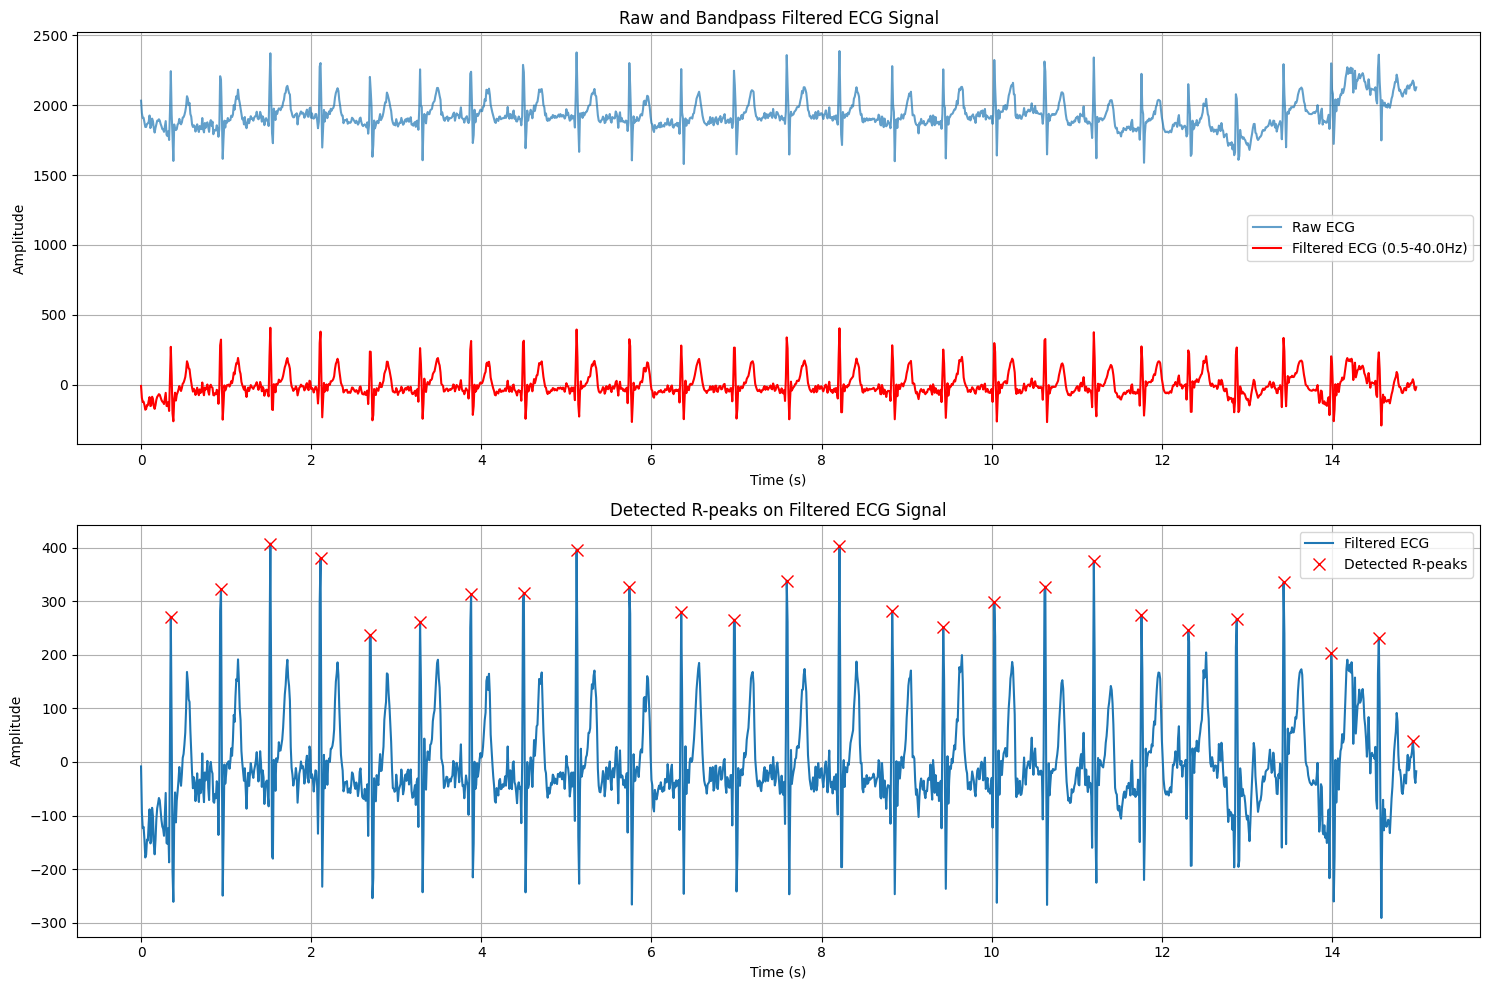

In [10]:
# --- How to run the processing ---

# Define the path to your input CSV file
input_file_path = "C:/Users/adity/Downloads/ecg/downloaded_ecg.csv"

# Define the path where you want to save the output plot
output_plot_file_path = "C:/Users/adity/Downloads/ecg/ecg_analysis_plot.png"

# Define the path for the output features CSV file
output_features_file_path = "C:/Users/adity/Downloads/ecg/ecg_features_detailed.csv"


# Call the process_ecg function
processed_features_df = process_ecg(
    input_csv_path=input_file_path,
    plot_path=output_plot_file_path,
    output_features_csv_path=output_features_file_path # This argument is now expected
)

# Display the extracted features DataFrame
if not processed_features_df.empty:
    print("\n--- Extracted Features ---")
    print(processed_features_df)
else:
    print("\nNo features were extracted, or an error occurred during processing.")
